<a href="https://colab.research.google.com/github/ngoax/MathAgent/blob/main/Tool_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sometimes colab throws an error for UTF-8, please then execute this code snippet and try again

In [15]:
import locale
def getpreferredencoding():
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Install dependencies

In [70]:
!pip install langchain
!pip install --upgrade --quiet numexpr
!pip install -qU langchain-google-genai
!pip install -qU langchain-docling
!pip install docling
!pip install langgraph
!pip install -U ollama
!pip install -U langchain-ollama
!pip install --upgrade --quiet  langchain-huggingface text-generation transformers google-search-results numexpr langchainhub sentencepiece jinja2 bitsandbytes accelerate

Set up Langsmith to be able to inspect agent later on ([generate access token](https://smith.langchain.com/))

In [3]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


Set up ollama

In [71]:
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True)
!ollama pull llama3.2:3b

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling dde5aa3fc5ff... 100% ▕▏ 2.0 GB                         
pulling 966de95ca8a6... 100% ▕▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕▏ 6.0 KB                         
pulling 56bb8bd477a5... 100% ▕▏   96 B                         
pulling 34bb5ab01051... 100% 

In [72]:
from langchain_ollama import ChatOllama
model = ChatOllama(
    model = "llama3.2:3b",
    temperature = 0.8,
    num_predict = 256,
    # other params ...
)

Set up math tool

In [73]:
import math
import numexpr

def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )


Set up pdf reader

In [74]:
from langchain_docling import DoclingLoader

def pdfReader(filepath: str) -> str:
  """ get file content using docling

  Args:
      filepath (str): path to file

  Returns:
      str: file content
  """
  loader = DoclingLoader(file_path=filepath)
  docs = loader.load()
  #print(docs)
  return docs[0].page_content

  #return docs

  # for d in docs[:3]:
  #     print(f"- {d.page_content=}")

Set up chatbot with tool-calling enabled ([credit](https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup))

In [75]:
from typing import Annotated
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
tools = [calculator, pdfReader]
model_with_tools = model.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[calculator, pdfReader])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

Draw graph

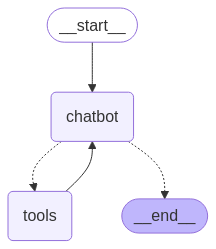

In [76]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Start chatbot

In [69]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What can you do?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what are the solutions for: /content/latex.pdf
Assistant: 
Assistant: whats 5+5?
ive got 5 apples and give 2 to a friend of mine, how many apples have i got the sum of 3 and 90 calculate 2 + 3 afterwards
Assistant: You've been given 5 apples initially.

After giving 2 apples to your friend, you're left with:

5 - 2 = 3 apples

Now, let's perform the calculations:

1. The sum of 3 and 90 is: 
   3 + 90 = 93

2. After performing this calculation, we move on to 2 + 3:
   2 + 3 = 5

So, you have 3 apples left.
User: q
Goodbye!


TODO
- build graph correctly (maybe have a look at [this page](https://langchain-ai.github.io/langgraph/how-tos/))
- improve pdf reader

Further readings
- [Tutorial on agents](https://python.langchain.com/docs/how_to/migrate_agent/) (did already tried some things with that)